In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import cv2

In [2]:
# 📥 Step 1: Load the labeled pose data
video_dir = '../data/videos'
video_url_hash = '16f4e9bce30465e27a1733c76b857886406430be608853c458a50ae5fb5f7828' # Adjust your video file here
pose_df = pd.read_csv(f'{video_dir}/{video_url_hash}/pose_data.csv')  # Contains frame, x_0, y_0, ..., z_n
labels_df = pd.read_csv(f'{video_dir}/{video_url_hash}/manual_labels.csv')  # Contains shot_id, start_frame, end_frame, label

In [3]:
# 📊 Step 2: Merge frame-level pose data with shot labels
def label_frames(pose_df, labels_df):
    pose_df['shot_label'] = None
    pose_df['shot_id'] = None
    for _, row in labels_df.iterrows():
        mask = pose_df['frame'].str.extract(r'(\d+)').astype(int)[0].between(row['start_frame'], row['end_frame'])
        pose_df.loc[mask, 'shot_label'] = row['label']
        pose_df.loc[mask, 'shot_id'] = row['shot_id']
    return pose_df.dropna(subset=['shot_label'])

pose_df = label_frames(pose_df, labels_df)
pose_df.sort_values('frame').head()

,frame,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,...,y_30,z_30,x_31,y_31,z_31,x_32,y_32,z_32,shot_label,shot_id
0,frame_1000.jpg,0.549377,0.532708,0.069814,0.547049,0.526331,0.062362,0.545964,0.526174,0.062346,...,0.813024,0.044641,0.458691,0.810567,0.005940,0.557274,0.820216,0.056457,drop,16
10,frame_1005.jpg,0.595322,0.492800,-0.046146,0.592557,0.486268,-0.041487,0.591942,0.486169,-0.041496,...,0.801628,0.152312,0.571692,0.822361,0.256558,0.568448,0.827383,0.139624,drop,16
19,frame_1010.jpg,0.643419,0.509379,0.018392,0.640670,0.501066,0.021655,0.639939,0.500743,0.021655,...,0.843560,-0.083671,0.582100,0.852711,0.116974,0.685108,0.864311,-0.094382,drop,16
30,frame_1015.jpg,0.690688,0.563617,0.002772,0.686025,0.554933,-0.000163,0.684666,0.555150,-0.000196,...,0.944080,-0.123438,0.611183,0.863983,0.295301,0.767007,0.938572,-0.142018,drop,16
41,frame_1020.jpg,0.679720,0.533101,0.082017,0.677136,0.525387,0.065735,0.675635,0.525374,0.065750,...,0.930552,0.037043,0.622883,0.866623,0.294803,0.767662,0.936431,0.032498,drop,16


In [4]:
# 🧹 Step 3: Preprocessing
features = [col for col in pose_df.columns if col.startswith(('x_', 'y_', 'z_'))]
scaler = StandardScaler()
pose_df[features] = scaler.fit_transform(pose_df[features])
pose_df.head()

,frame,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,...,y_30,z_30,x_31,y_31,z_31,x_32,y_32,z_32,shot_label,shot_id
0,frame_1000.jpg,0.363221,0.693680,-0.197764,0.362863,0.673772,-0.176747,0.363714,0.661852,-0.176858,...,0.167556,0.193819,-0.262454,-0.124066,-0.106358,0.122609,0.063990,0.333553,drop,16
10,frame_1005.jpg,0.776415,-0.532484,-1.701895,0.772084,-0.562039,-1.576039,0.777615,-0.569906,-1.576138,...,-0.020202,1.100498,0.772639,0.090127,1.899845,0.218492,0.181934,1.000421,drop,16
19,frame_1010.jpg,1.208962,-0.023078,-0.864771,1.204729,-0.105570,-0.725240,1.209694,-0.121173,-0.725170,...,0.670676,-0.886673,0.867975,0.641287,0.782468,1.219469,0.789661,-0.875938,drop,16
30,frame_1015.jpg,1.634065,1.643366,-1.067371,1.612574,1.556041,-1.019229,1.612329,1.554001,-1.019618,...,2.326852,-1.221544,1.134373,0.845996,2.209981,1.922182,2.011806,-1.257904,drop,16
41,frame_1020.jpg,1.535430,0.705756,-0.039481,1.532640,0.644648,-0.131294,1.531038,0.637219,-0.130992,...,2.103951,0.129841,1.241550,0.893927,2.205996,1.927805,1.976565,0.141433,drop,16


In [5]:
def create_padded_sequences(df, max_len=92):
    X, y = [], []

    # Encode shot labels
    label_encoder = LabelEncoder()
    df['shot_label_enc'] = label_encoder.fit_transform(df['shot_label'])
    df = df.copy()  # Defragment DataFrame to avoid PerformanceWarning

    # Group by shot
    for shot_id, group in df.groupby('shot_id'):
        seq = group.sort_values(by='frame')[features].values
        label = group['shot_label_enc'].iloc[0]

        # Pad the sequence
        padded_seq = pad_sequences([seq], maxlen=max_len, dtype='float32', padding='post', truncating='post')[0]
        X.append(padded_seq)
        y.append(label)

    return np.array(X), to_categorical(y), label_encoder

# Parameters
max_len = 92  # The length to which all sequences will be padded
num_features = len(features)

# Run it
X, y, label_encoder = create_padded_sequences(pose_df, max_len=max_len)

/var/folders/ny/97nfvbms25lb47qpfvgmgfc40000gn/T/ipykernel_35606/3093151775.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['shot_label_enc'] = label_encoder.fit_transform(df['shot_label'])


In [6]:
# ✂️ Step 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Compute class weights (only if you have class imbalance)
labels_train = np.argmax(y_train, axis=1)
class_weights_array = compute_class_weight('balanced', classes=np.unique(labels_train), y=labels_train)
class_weight_dict = dict(enumerate(class_weights_array))

# Step 6: Build the model
timesteps = X.shape[1]
features = X.shape[2]
model = Sequential([
    Input(shape=(timesteps, features)),
    LSTM(64, return_sequences=False, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 7: Train the model
model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

# 📈 Step 8: Evaluate and predict
loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.2f}")

# 🧠 Predict some labels
preds = model.predict(X_test[:5])
pred_labels = label_encoder.inverse_transform(np.argmax(preds, axis=1))
true_labels = label_encoder.inverse_transform(np.argmax(y_test[:5], axis=1))
print("Predicted:", pred_labels)
print("True:", true_labels)

/Users/jin-holee/github/Jin-HoMLee/shuttle-insights/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,599 (182.03 KB)

 Trainable params: 46,599 (182.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.0588 - loss: 1.9461 - val_accuracy: 0.4000 - val_loss: 1.9440
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1176 - loss: 1.9472 - val_accuracy: 0.4000 - val_loss: 1.9427
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1176 - loss: 1.9456 - val_accuracy: 0.4000 - val_loss: 1.9423
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3529 - loss: 1.9438 - val_accuracy: 0.4000 - val_loss: 1.9408
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2353 - loss: 1.9452 - val_accuracy: 0.4000 - val_loss: 1.9384
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1176 - loss: 1.9462 - val_accuracy: 0.4000 - val_loss: 1.9361
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1176 - loss: 1.9484 - val_accuracy: 0.4000 - val_loss: 1.9358
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1765 - loss: 1.9438 - val_accuracy: 0.4000 - val_loss: 1.9358

## Error Analysis

### ✅ Step-by-step error analysis and visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Total misclassified samples: 4
              precision    recall  f1-score   support

       block       0.00      0.00      0.00         0
       clear       0.00      0.00      0.00         0
       drive       0.00      0.00      0.00         0
        drop       0.20      1.00      0.33         1
        lift       0.00      0.00      0.00         2
    net shot       0.00      0.00      0.00         2
       smash       0.00      0.00      0.00         0

    accuracy                           0.20         5
   macro avg       0.03      0.14      0.05         5
weighted avg       0.04      0.20      0.07         5



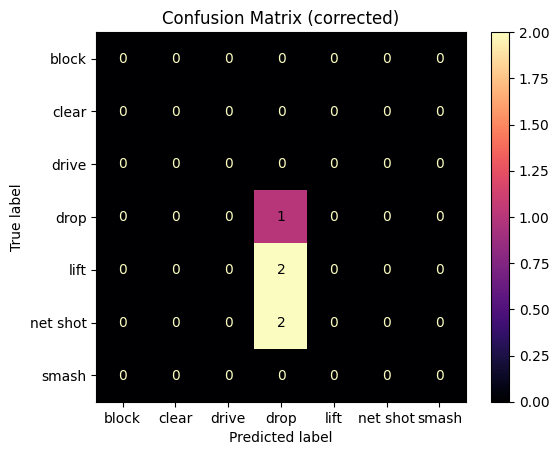

In [7]:
# Ensure you're using the correct class order
class_names = label_encoder.classes_
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

# Get misclassified indices
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Total misclassified samples: {len(misclassified_indices)}")

# Optional: classification report
labels = np.arange(len(label_encoder.classes_))  # [0, 1, 2, 3, 4]
print(classification_report(
    y_true,
    y_pred,
    labels=labels,
    target_names=label_encoder.classes_,
    zero_division=0  # optional: avoids warnings on missing classes
))

# Specify labels explicitly to enforce correct order
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

# Plot with correct class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='magma')
plt.title("Confusion Matrix (corrected)")
plt.show()

# Conclusion

- general workflow works
- as already mentioned in `01_pose_overlay_video.ipynb`, change model for pose analysis
- generate more labeled data (e.g. by using a chrome browser extension)
- research/improve predictive model (LSTM might be outdated now)